# GPS trajectory clastering

In [2]:
import geopy.distance
import gmplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.cluster import DBSCAN
from sklearn import metrics

from dipy.segment.metric import Metric
from dipy.segment.metric import ResampleFeature

# Enable inline plotting
%matplotlib inline

**Input data**

In [21]:
user = '001'
userdata = 'Data\\' + user + '\\Trajectory\\'

filelist = os.listdir(userdata) 
names = ['lat','lng','zero','alt','days','date','time']

df_list = [pd.read_csv(userdata + f,header=6,names=names,index_col=False) for f in filelist]
df = pd.concat(df_list, ignore_index=True)

df.drop(['zero', 'days'], axis=1, inplace=True)
df.head(10)

,lat,lng,alt,date,time
0,39.984198,116.319322,492,2008-10-23,05:53:06
1,39.984224,116.319402,492,2008-10-23,05:53:11
2,39.984211,116.319389,492,2008-10-23,05:53:16
3,39.984217,116.319422,491,2008-10-23,05:53:21
4,39.984710,116.319865,320,2008-10-23,05:53:23
5,39.984674,116.319810,325,2008-10-23,05:53:28
6,39.984623,116.319773,326,2008-10-23,05:53:33
7,39.984606,116.319732,327,2008-10-23,05:53:38
8,39.984555,116.319728,324,2008-10-23,05:53:43
9,39.984579,116.319769,309,2008-10-23,05:53:48


**Data reduced**

In [22]:
# data is recorded every 1~5 seconds, which is too frequent. Reduce it to every minute
df_min = df.iloc[::12, :]
df_min.head(10)

,lat,lng,alt,date,time
0,39.984198,116.319322,492,2008-10-23,05:53:06
12,39.984611,116.319822,304,2008-10-23,05:53:58
24,39.984252,116.320826,227,2008-10-23,05:54:43
36,39.983916,116.320980,180,2008-10-23,05:55:39
48,39.982688,116.321225,154,2008-10-23,05:56:17
60,39.981441,116.321305,97,2008-10-23,05:56:55
72,39.980291,116.321430,81,2008-10-23,05:57:32
84,39.979675,116.321805,100,2008-10-23,05:58:18
96,39.979546,116.322926,115,2008-10-23,05:59:11
108,39.979758,116.324513,98,2008-10-23,05:59:47


**Map operations**

In [25]:
# declare the center of the map, and how much we want the map zoomed in
gmap = gmplot.GoogleMapPlotter(df_min.lat[0], df_min.lng[0], 11)
gmap.plot(df_min.lat, df_min.lng)

# html generating
gmap.draw("user001_map.html")

Samlpe of tracks for user


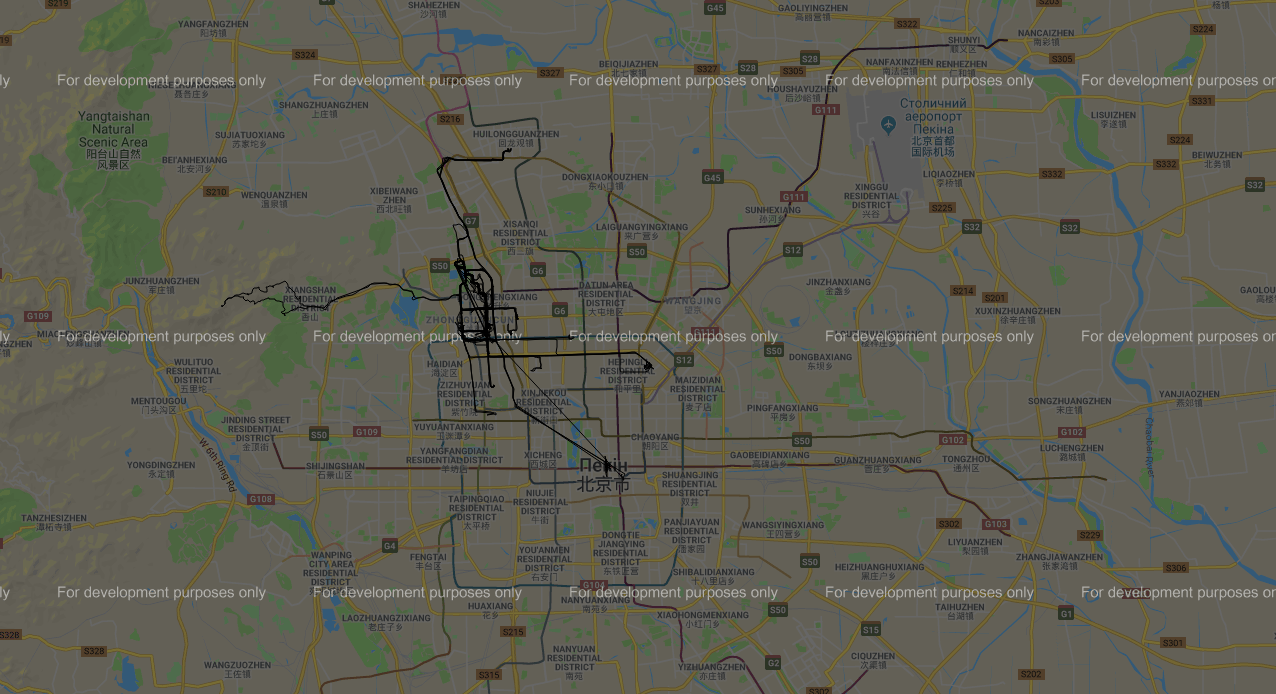

In [32]:
from IPython.display import Image
print('Samlpe of tracks for user')
Image(filename = "user001_map.png", width=700, height=500)

**Koordinate operations**

In [33]:
coords = df_min[['lat', 'lng']]
coords.to_numpy()

array([[ 39.984198, 116.319322],
       [ 39.984611, 116.319822],
       [ 39.984252, 116.320826],
       ...,
       [ 39.978249, 116.327146],
       [ 39.978113, 116.327042],
       [ 39.978046, 116.326701]])

**Clasters point evaluating**

In [34]:
# represent GPS points as (lat, lon)
coords = df_min.as_matrix(columns=['lat', 'lng'])

# earth's radius in km
kms_per_radian = 6371.0088
# define epsilon as 0.5 kilometers, converted to radians for use by haversine
epsilon = 0.5 / kms_per_radian

# eps is the max distance that points can be from each other to be considered in a cluster
# min_samples is the minimum cluster size (everything else is classified as noise)
db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters (ignore noisy samples which are given the label -1)
num_clusters = len(set(cluster_labels) - set([-1]))

print('Clustered ' + str(len(df_min)) + ' points to ' + str(num_clusters) + ' clusters')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Clustered 9045 points to 4 clusters


**Put clasters points to DataFrame**

In [35]:
# turn the clusters in to a pandas series
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters

0    [[39.984198, 116.319322], [39.984611, 116.3198...
1    [[40.069857, 116.333592], [40.069868, 116.3351...
2    [[39.909038, 116.41192099999999], [39.908906, ...
3    [[39.967153, 116.43158700000001], [39.96669699...
dtype: object

**Clasters operations**

In [36]:
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

# get the centroid point for each cluster
centermost_points = clusters.map(get_centermost_point)
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

**Claster vizualization**

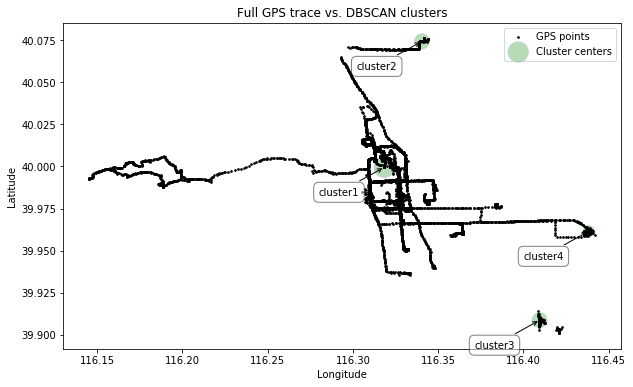

In [37]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lon'][0], rep_points['lat'][0], c='#99cc99', edgecolor='None', alpha=0.7, s=450)
ax.scatter(rep_points['lon'][1], rep_points['lat'][1], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['lon'][2], rep_points['lat'][2], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['lon'][3], rep_points['lat'][3], c='#99cc99', edgecolor='None', alpha=0.7, s=150)
df_scatter = ax.scatter(df_min['lng'], df_min['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full GPS trace vs. DBSCAN clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['GPS points', 'Cluster centers'], loc='upper right')

labels = ['cluster{0}'.format(i) for i in range(1, num_clusters+1)]
for label, x, y in zip(labels, rep_points['lon'], rep_points['lat']):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-25, -30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

**Time operations**

In [38]:
# Get the hours for each cluster
M = []
def get_hours(row):
    t = df_min[(df_min['lat']==row[0]) & (df_min['lng']==row[1])]['time'].iloc[0]
    return t[:t.index(':')]
for i in range(num_clusters):
    hours = np.apply_along_axis(get_hours, 1, clusters[i]).tolist()
    M.append(list(map(int, hours)))

Plot time for claster

Text(0.04, 0.5, '# of GPS points')

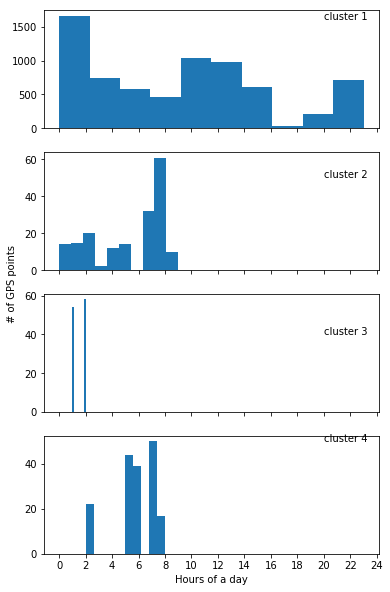

In [40]:
f, axarr = plt.subplots(4, sharex=True, figsize=(6,10))
axarr[0].hist(M[0])
axarr[0].text(20, 1600, "cluster 1")
axarr[1].hist(M[1])
axarr[1].text(20, 50, "cluster 2")
axarr[2].hist(M[2])
axarr[2].text(20, 40, "cluster 3")
axarr[3].hist(M[3])
axarr[3].text(20, 50, "cluster 4")
axarr[3].set_xlabel("Hours of a day")
plt.xticks(np.arange(0, 25, 2.0))
f.text(0.04, 0.5, '# of GPS points', va='center', rotation='vertical')